### <overview를 통해 로맨스 영화 장르 분류> 

[자연어 전처리]
- [1] 데이터 준비
    - 모듈 불러오기
    - 파일 데이터 프레임으로 불러오기
    - 파일 확인
- [2] 전처리
    - [2-1] 기본 전처리 : 불필요한 컬럼 삭제, 결측치 처리, 중복값 확인 후 처리
    - [2-2] 텍스트 전처리
    - [2-3] 토큰화 ▶ 정수화

- [3] 모델 생성
    - [3-1] LSTM 모델 클래스 생성
    - [3-2] 데이터분리/데이터셋/데이터 로더 생성
- [4] 학습


[1] 데이터 준비

In [107]:
# 모듈 불러오기
import pandas as pd

In [108]:
# 파일 불러오기
movieDF = pd.read_csv('movie_data_all.csv', names=['source', 'title', 'genre', 'running time', 'score', 'overview', '-', '--', 'director'])
#movieDF.head()

In [109]:
# 불필요한 컬럼 삭제
movieDF = movieDF[['genre', 'overview']]

In [110]:
print(f'movieDF.shape = {movieDF.shape}]\n')
print(f'movieDF.info()\n{movieDF.info()}\n')
print(f'movieDF.head()\n{movieDF.head()}')

movieDF.shape = (9300, 2)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9300 entries, 0 to 9299
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   genre     9270 non-null   object
 1   overview  9267 non-null   object
dtypes: object(2)
memory usage: 145.4+ KB
movieDF.info()
None

movieDF.head()
                                          genre  \
0                    Science Fiction, Adventure   
1  Animation, Action, Adventure, Comedy, Family   
2   Action, Science Fiction, Adventure, Fantasy   
3   Science Fiction, Action, Fantasy, Adventure   
4                             Action, Thrillerp   

                                            overview  
0  Follow the mythic journey of Paul Atreides as ...  
1  Po is gearing up to become the spiritual leade...  
2  Following their explosive showdown, Godzilla a...  
3  Gurus in the late Goryeo dynasty try to obtain...  
4  When an explosion at an oil well threatens hun...  

[2] 데이터 전처리 <hr>
[2-1] 기본 전처리

In [111]:
print('결측값 :\n', movieDF.isnull().sum(), '\n')
print('중복값 :', movieDF.duplicated().sum())

결측값 :
 genre       30
overview    33
dtype: int64 

중복값 : 31


In [112]:
# 결측값 & 중복값 삭제
movieDF.dropna(inplace=True)
movieDF.drop_duplicates(keep='first', inplace=True)

print('결측값 :\n', movieDF.isnull().sum(), '\n')
print('중복값 :', movieDF.duplicated().sum())

결측값 :
 genre       0
overview    0
dtype: int64 

중복값 : 0


In [113]:
# 모든 행을 출력할 수 있도록 설정
#pd.set_option('display.max_rows', None)

# 클래스 확인
movieDF['genre'].value_counts()

genre
Drama                                                  465
Comedy                                                 306
Drama, Romance                                         276
Comedy, Romance                                        177
Horror                                                 167
                                                      ... 
Comedy, Adventure, Family                                1
Horror, Romance                                          1
Science Fiction, Animation, Action, Crime, Thriller      1
War, History, Action, Adventure, Drama, Romance          1
Science Fiction, Horror, Mystery, Thriller               1
Name: count, Length: 2234, dtype: int64

In [114]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 50)) 
# movieDF['genre'].value_counts().plot(kind='barh')

In [115]:
# 장르 안에 로맨스가 포함되어 있으면 로맨스로 1, 그 밖의 영화는 0으로 분류
def classify_romance_genre(genre) : 
    if 'Romance' in genre :
        return 1
    else :
        return 0

In [116]:
# 새 컬럼 추가
movieDF['genre_romance'] = movieDF['genre'].apply(classify_romance_genre)

In [117]:
# 클래스 확인.
movieDF['genre_romance'].value_counts()

genre_romance
0    7737
1    1489
Name: count, dtype: int64

In [118]:
# 피처, 레이블 분리
labelSR = movieDF['genre_romance']
featureDF = movieDF['overview'].to_frame()
print(type(labelSR), type(featureDF))

<class 'pandas.core.series.Series'> <class 'pandas.core.frame.DataFrame'>


[2-2] 텍스트 전처리

In [119]:
# spacy 설치
#!pip install spacy
#!pip show spacy

# 토큰화에 필요한 모듈 설치
#!python -m spacy download en_core_web_sm

In [120]:
import spacy
nlp = spacy.load('en_core_web_sm')

- 불용어 제거 

In [121]:
import re
from spacy.lang.en.stop_words import STOP_WORDS

tokenList = []
count = 0
for idx in range(featureDF.shape[0]):
    sentence = featureDF.iloc[idx][0]
    #print(f'[{idx}] :', sentence)
    doc = nlp(sentence)
    tokens = []
    for token in doc :
        #print(token.text)

        #영어와 숫자를 제외 삭제. 소문자로 통일.
        token = re.sub(r"[^a-z0-9]", "", token.text.lower())

        # 불용어 불포함, 공백 없음, 2글자 이상일 경우 tokenList에 추가
        if token not in STOP_WORDS and token not in "" and len(token)>=2 : 
            tokens.append(token)
    tokenList.append(tokens)


    
    #print(tokens)
#테스트용
    # count += 1
    # if count == 5 : break

In [122]:
print(len(tokenList))
print(tokenList[0])
featureDF['tokens'] = tokenList

9226
['follow', 'mythic', 'journey', 'paul', 'atreides', 'unites', 'chani', 'fremen', 'path', 'revenge', 'conspirators', 'destroyed', 'family', 'facing', 'choice', 'love', 'life', 'fate', 'known', 'universe', 'paul', 'endeavors', 'prevent', 'terrible', 'future', 'foresee']


In [123]:
print(featureDF.head())

                                            overview  \
0  Follow the mythic journey of Paul Atreides as ...   
1  Po is gearing up to become the spiritual leade...   
2  Following their explosive showdown, Godzilla a...   
3  Gurus in the late Goryeo dynasty try to obtain...   
4  When an explosion at an oil well threatens hun...   

                                              tokens  
0  [follow, mythic, journey, paul, atreides, unit...  
1  [po, gearing, spiritual, leader, valley, peace...  
2  [following, explosive, showdown, godzilla, kon...  
3  [gurus, late, goryeo, dynasty, try, obtain, fa...  
4  [explosion, oil, threatens, hundreds, lives, c...  


In [124]:
from collections import Counter
word_counts = Counter()

'''
- Counter 객체는 리스트 요소의 값과 요소의 갯수를 카운트하여 저장. 
- 카운터 객체는 .update 메소드로 계속 업데이트 가능.'''

# 각 행의 토큰 리스트를 가져와서 Counter 객체 업데이트
for tokens in featureDF['tokens']:
    word_counts.update(tokens)

# 업데이트된 Counter 객체를 출력하거나 필요한 작업 수행
print(word_counts)

sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

Counter({'life': 1407, 'new': 1261, 'world': 1226, 'young': 1197, 'family': 956, 'man': 907, 'find': 827, 'old': 680, 'love': 677, 'time': 633, 'help': 618, 'friends': 608, 'years': 599, 'woman': 598, 'finds': 589, 'school': 552, 'home': 549, 'year': 542, 'father': 538, 'story': 523, 'mysterious': 519, 'war': 501, 'soon': 496, 'girl': 485, 'save': 480, 'group': 473, 'nt': 472, 'lives': 471, 'way': 470, 'wife': 459, 'high': 448, 'town': 446, 'city': 444, 'son': 426, 'day': 425, 'daughter': 422, 'mother': 419, 'friend': 416, 'takes': 406, 'team': 404, 'secret': 384, 'death': 383, 'begins': 382, 'people': 349, 'set': 346, 'discovers': 346, 'boy': 332, 'meets': 328, 'named': 327, 'past': 325, 'fight': 319, 'evil': 313, 'goes': 310, 'house': 305, 'best': 304, 'stop': 304, 'earth': 301, 'order': 301, 'small': 301, 'true': 300, 'night': 299, 'gets': 299, 'mission': 298, 'forced': 292, 'american': 289, 'battle': 288, 'police': 287, 'journey': 283, 'discover': 279, 'brother': 278, 'men': 262, '

In [125]:
labels =[]
counts = []
for idx, (wrd, cnt) in enumerate(sorted_word_counts) :
    if idx<20 :
        labels.append(wrd)
        counts.append(cnt)
    else : break

print(labels, counts)

['life', 'new', 'world', 'young', 'family', 'man', 'find', 'old', 'love', 'time', 'help', 'friends', 'years', 'woman', 'finds', 'school', 'home', 'year', 'father', 'story'] [1407, 1261, 1226, 1197, 956, 907, 827, 680, 677, 633, 618, 608, 599, 598, 589, 552, 549, 542, 538, 523]


In [126]:
# 
frequency_one = [] 
vocab = []
for idx, (wrd, cnt) in enumerate(sorted_word_counts) :
    if cnt == 1 :
        frequency_one.append(wrd)
    else :
        vocab.append(wrd)


In [127]:
#vocab

In [128]:
#word_vocab = dict(word_counts.items())
#word_vocab

In [129]:
#!pip install squarify

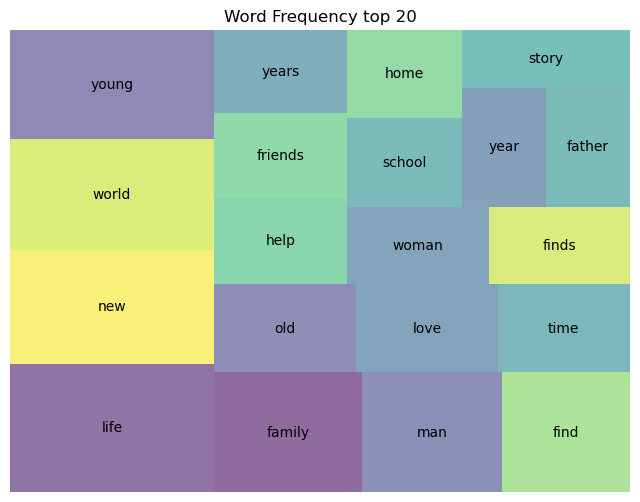

In [130]:
import squarify
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
squarify.plot(sizes=counts, label=labels, alpha=0.6)
plt.axis('off')  # 축 제거
plt.title('Word Frequency top 20')
plt.show()

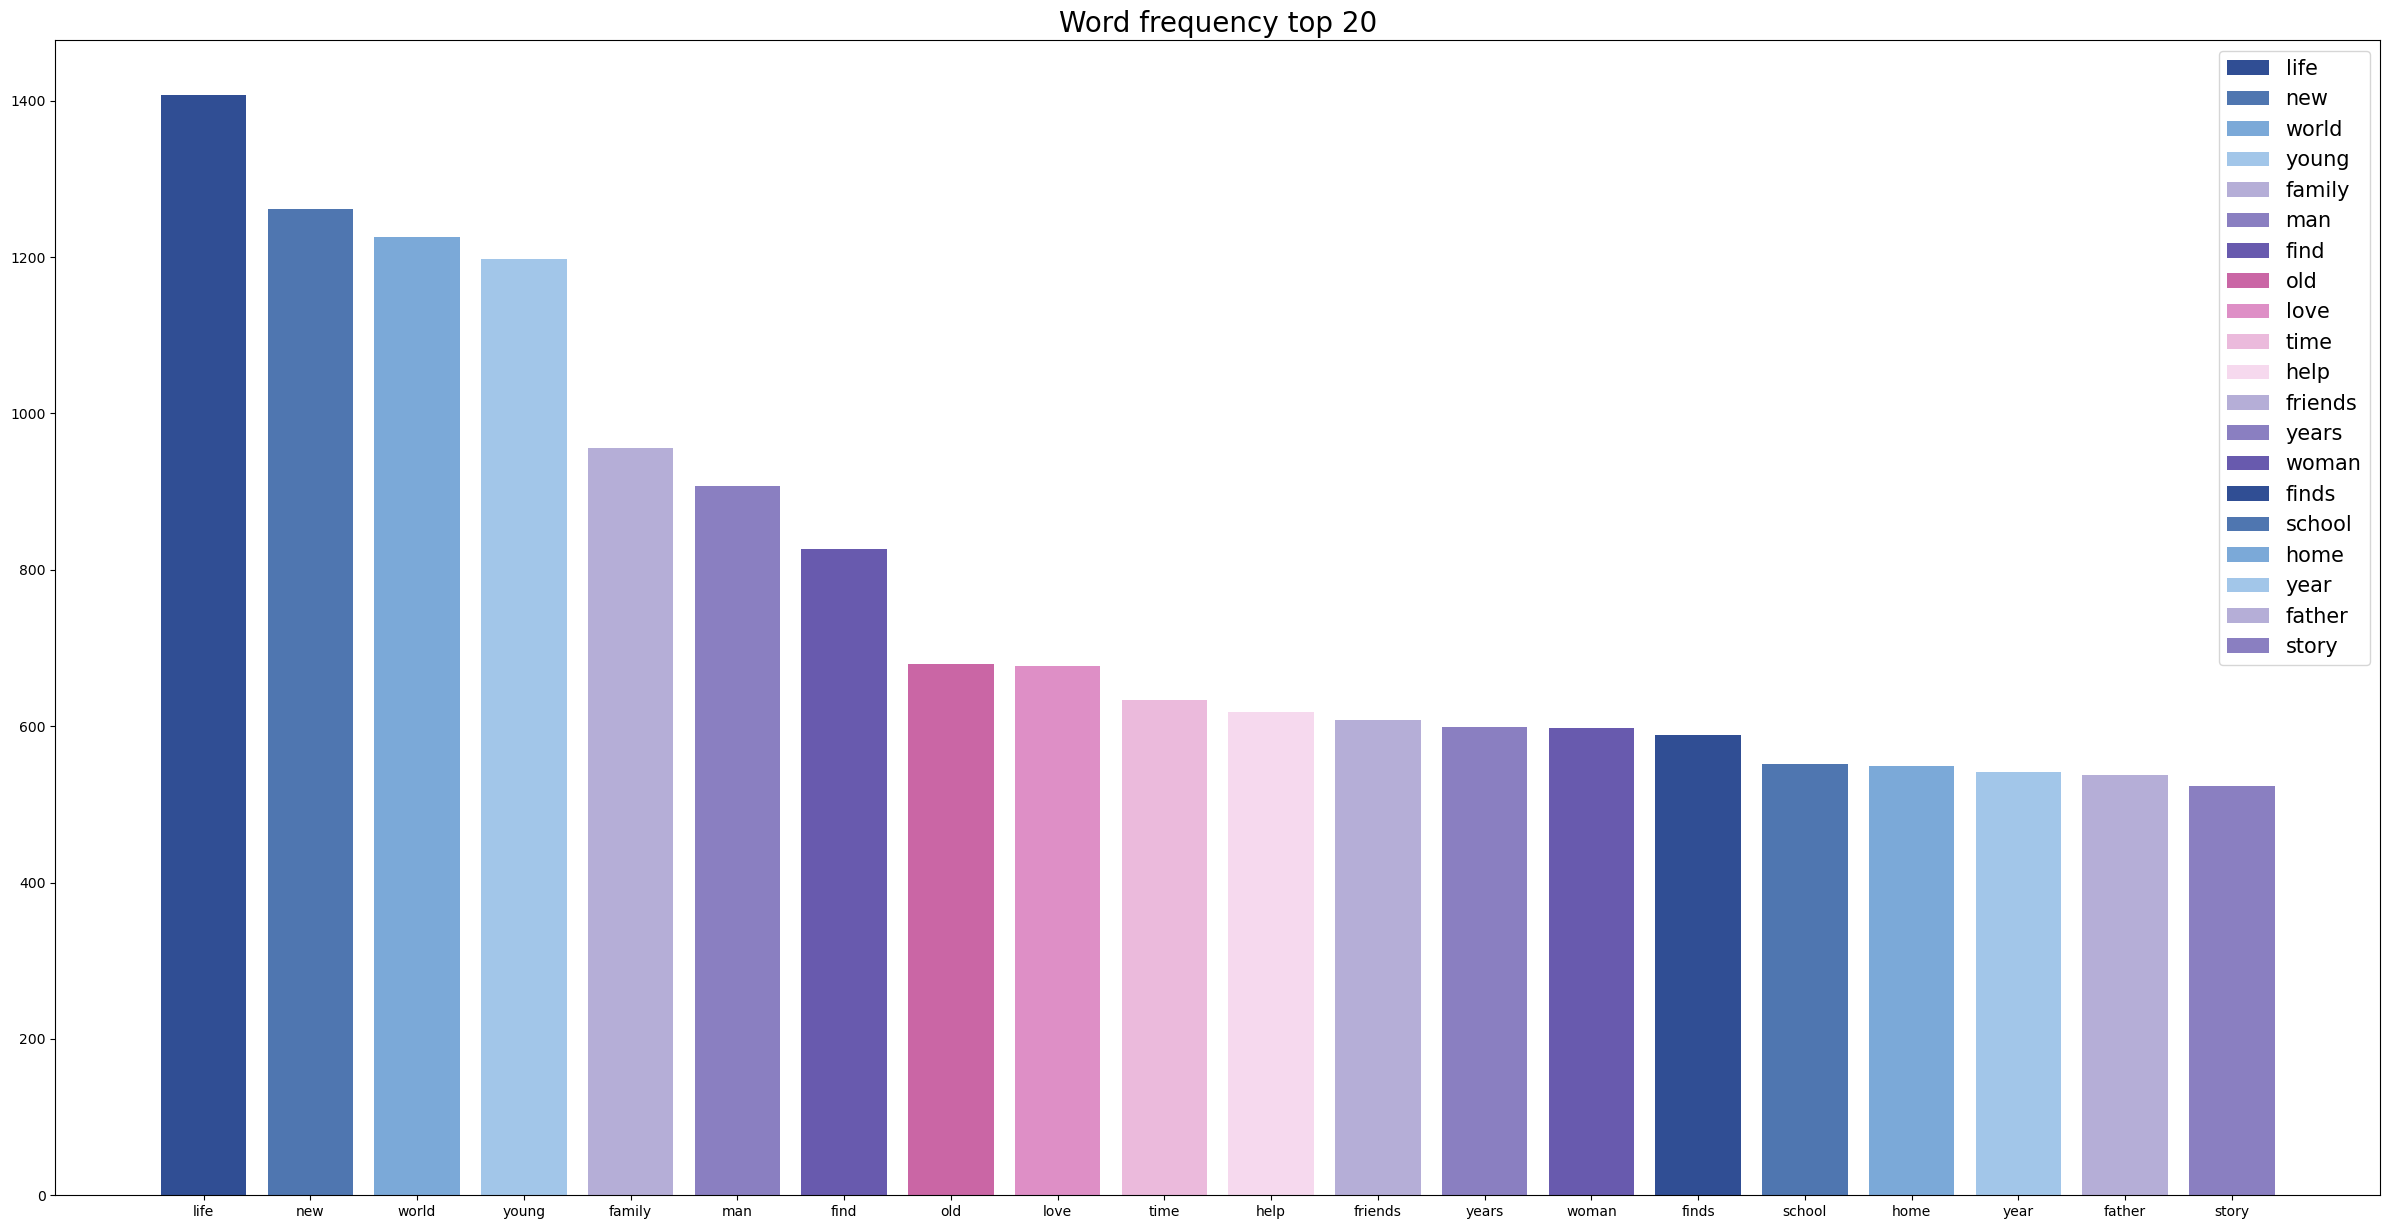

In [168]:
colorList = ['#B5DDEF', '#91B8DF', '#5F99D2', '#1C66AF', '#685AAE', '#8A7FC1', '#B5AED7', '#F6D9EE', '#EBBADC', '#DE8FC6', '#CA66A5', '#685AAE', '#8A7FC1', '#B5AED7']
colorList2 = ['#304E94', '#4F76B0', '#7BA9D8', '#A2C6E9', '#B5AED7', '#8A7FC1', '#685AAE', '#CA66A5', '#DE8FC6', '#EBBADC', '#F6D9EE', '#B5AED7', '#8A7FC1', '#685AAE']

plt.figure(figsize=(30, 15))
plt.title("Word frequency top 20", fontsize = 20)
bars = plt.bar(labels, counts, color = colorList2)
plt.legend(bars, labels, fontsize = 15)
plt.show()

In [132]:
# vocab = nlp.vocab
# print(list(vocab.strings)[:550])

In [133]:
wordList = ['<pad>', '<unk>']
for word in vocab :
    wordList.append(word)

# count = 0
# for (word, _) in sorted_word_counts :
#     #print(word)
#     wordList.append(word)
    # count += 1
    # if count == 5 : break

In [134]:
#pd.DataFrame(wordList).to_csv('vocab.csv')
#print('csv변환 완료')

In [135]:
# 인코딩 : 문자 -> 숫자
encode = {token : idx for idx, token in enumerate(wordList)}
print(encode)

{'<pad>': 0, '<unk>': 1, 'life': 2, 'new': 3, 'world': 4, 'young': 5, 'family': 6, 'man': 7, 'find': 8, 'old': 9, 'love': 10, 'time': 11, 'help': 12, 'friends': 13, 'years': 14, 'woman': 15, 'finds': 16, 'school': 17, 'home': 18, 'year': 19, 'father': 20, 'story': 21, 'mysterious': 22, 'war': 23, 'soon': 24, 'girl': 25, 'save': 26, 'group': 27, 'nt': 28, 'lives': 29, 'way': 30, 'wife': 31, 'high': 32, 'town': 33, 'city': 34, 'son': 35, 'day': 36, 'daughter': 37, 'mother': 38, 'friend': 39, 'takes': 40, 'team': 41, 'secret': 42, 'death': 43, 'begins': 44, 'people': 45, 'set': 46, 'discovers': 47, 'boy': 48, 'meets': 49, 'named': 50, 'past': 51, 'fight': 52, 'evil': 53, 'goes': 54, 'house': 55, 'best': 56, 'stop': 57, 'earth': 58, 'order': 59, 'small': 60, 'true': 61, 'night': 62, 'gets': 63, 'mission': 64, 'forced': 65, 'american': 66, 'battle': 67, 'police': 68, 'journey': 69, 'discover': 70, 'brother': 71, 'men': 72, 'agent': 73, 'living': 74, 'work': 75, 'film': 76, 'face': 77, 'long

In [136]:
# overview 토큰을 정수로 변환
UNK_ID = encode.get('<unk>')
id = [[encode.get(token, UNK_ID) for token in text] for text in featureDF['tokens']]    
print(id)
print(len(id))

#featureDF['encoded'] = id 

[[621, 7529, 69, 536, 11199, 4706, 1, 11200, 503, 131, 11201, 826, 6, 890, 911, 10, 2, 238, 115, 437, 536, 6546, 492, 941, 88, 11202], [2663, 6547, 2366, 251, 1414, 384, 456, 135, 537, 473, 438, 3, 1514, 1515, 9006, 2074, 337, 1158, 152, 7530, 11203, 1462, 51], [246, 2261, 1738, 1199, 652, 669, 5780, 9007, 354, 355, 4, 3420, 504], [1, 241, 1, 2158, 148, 2829, 3200, 1971, 1066, 343, 5781, 431, 214, 1200, 1294, 95, 335, 3985, 465, 942, 11, 740, 3674, 1739], [2159, 1415, 328, 1872, 29, 2160, 41, 152, 119, 519, 2664, 1, 6548], [113, 9008, 588, 4335, 40, 102, 6549, 1873, 4707, 11204, 70, 2075], [46, 777, 1463, 4, 636, 4708, 2665, 3986, 6550, 58, 1562, 5, 6551, 4709, 9009, 3987, 3988, 1740, 943, 323, 482, 9010, 1092, 2510, 11205], [65, 457, 3675, 51, 11206, 5782, 9011, 5783, 97, 5, 138, 1616, 120, 11207, 175, 119, 798], [1563, 844, 215, 2367, 9012, 1, 563, 194, 4710, 891, 1121], [764, 338, 1671, 226, 39, 1159, 79, 483, 183, 282, 827, 174], [216, 115, 6552, 1295, 1040, 589, 1, 2993, 4336, 299

[+] 패딩

In [137]:
cnt = 0 
for encoded in id :
    #print(encoded)
    max_length = 0
    for i in id :
        if max_length<len(i) :
            max_length = len(i)
    padded_id = []
    for i in id :
        if len(i) < max_length :
            padded_id.append(i + [0]*(max_length-len(i)))
        else:
            padded_id.append(i)

print(max_length)


97


In [138]:
print(padded_id[5])

[113, 9008, 588, 4335, 40, 102, 6549, 1873, 4707, 11204, 70, 2075, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[3] 모델 생성 <hr>
[3-1] LSTM 모델 클래스 생성

In [139]:
from torch import nn as nn

class LSTM(nn.Module) :
    def __init__(self, n_vocab, hidden_dim, embedding_dim, n_layers, bidirectional=False) :
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings = n_vocab,
                                      embedding_dim = embedding_dim,
                                      padding_idx = 0)
        
        self.model = nn.LSTM(input_size = embedding_dim,
                             hidden_size = hidden_dim,
                             num_layers = n_layers,
                             bidirectional=bidirectional,
                             batch_first = True)
        self.classifier = nn.Linear(hidden_dim, 1)

    def forward(self, inputs) :
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:, -1, :]
        logits = self.classifier(last_output)
        return logits

In [140]:
from torch import nn as nn

class LSTM_with_dropout(nn.Module) :
    def __init__(self, n_vocab, hidden_dim, embedding_dim, n_layers, dropout, bidirectional=False) :
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings = n_vocab,
                                      embedding_dim = embedding_dim,
                                      padding_idx = 0)
        
        self.model = nn.LSTM(input_size = embedding_dim,
                             hidden_size = hidden_dim,
                             num_layers = n_layers,
                             bidirectional=bidirectional,
                             dropout = dropout,
                             batch_first = True)
        self.classifier = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs) :
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:, -1, :]
        logits = self.classifier(last_output)
        return logits

- [3-2] 데이터분리/데이터셋/데이터 로더 생성

In [141]:
index = list(range(0,9226))
dataDF = pd.DataFrame(padded_id, index=index)
dataDF.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,621,7529,69,536,11199,4706,1,11200,503,131,...,0,0,0,0,0,0,0,0,0,0
1,2663,6547,2366,251,1414,384,456,135,537,473,...,0,0,0,0,0,0,0,0,0,0
2,246,2261,1738,1199,652,669,5780,9007,354,355,...,0,0,0,0,0,0,0,0,0,0
3,1,241,1,2158,148,2829,3200,1971,1066,343,...,0,0,0,0,0,0,0,0,0,0
4,2159,1415,328,1872,29,2160,41,152,119,519,...,0,0,0,0,0,0,0,0,0,0


In [142]:
# dataDF.to_csv('encoded.csv')
# print('csv 변환 완료')

In [143]:
from sklearn.model_selection import train_test_split
Xtrn, Xtst, ytrn, ytst = train_test_split(dataDF, labelSR, test_size=0.2, random_state = 10, shuffle = True, stratify = labelSR)

In [144]:
print(f'Xtrn.shape = {Xtrn.shape}')
print(f'Xtst.shape = {Xtst.shape}')
print(f'ytrn.shape = {ytrn.shape}')
print(f'ytst.shape = {ytst.shape}')

Xtrn.shape = (7380, 97)
Xtst.shape = (1846, 97)
ytrn.shape = (7380,)
ytst.shape = (1846,)


In [145]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
XtrnNP = np.array(Xtrn)
XtstNP = np.array(Xtst)
ytrnNP = np.array(ytrn)
ytstNP = np.array(ytst)



데이터셋 생성 -> 데이터 로더 생성

In [146]:
class myDataset(Dataset) :
    def __init__(self, feature, target) :
        super().__init__()
        self.feature = torch.IntTensor(feature)
        self.target = torch.FloatTensor(target)
        self.length = self.feature.shape[0]

    def __len__(self) : 
        return self.length
    
    def __getitem__(self, index) :
        feature = self.feature[index]
        target = self.target[index]
        return feature, target

In [147]:
trainDS = myDataset(XtrnNP, ytrnNP)
testDS = myDataset(XtstNP, ytstNP)

In [148]:
BATCH_SIZE = 32
trainDL = DataLoader(trainDS, BATCH_SIZE, shuffle = True)
testDL = DataLoader(testDS, BATCH_SIZE, shuffle = True)

In [149]:
HIDDEN_SIZE = 32 # 64 -> 32
EMBEDD_DIM  = 64 # 128 -> 64
VOCAB_SIZE  = len(wordList)
NUM_LAYERS = 1
BATCH_SIZE  = 32
LR = 0.1
DROPOUT = 0.55

In [150]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [151]:
# n_vocab, hidden_dim, embedding_dim, n_layers, bidirectional=False
#mdl = LSTM(VOCAB_SIZE, HIDDEN_SIZE, EMBEDD_DIM, NUM_LAYERS).to(DEVICE)
mdl = LSTM_with_dropout(VOCAB_SIZE, HIDDEN_SIZE, EMBEDD_DIM, NUM_LAYERS, DROPOUT).to(DEVICE)


c:\ProgramData\anaconda3\envs\NLP_38\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.55 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [152]:
import torch.optim as optim
CRITERION = nn.BCEWithLogitsLoss()
OPTIMIZER = optim.AdamW(mdl.parameters(), lr=LR)
SCHEDULER = optim.lr_scheduler.StepLR(OPTIMIZER, 1.0, gamma=0.1)

In [153]:
#from sklearn.metrics import accuracy_score

In [154]:
def train(model, dataLoader, criterion, optimizer, device) :
    model.eval()
    lossList = []
    accuracyList = []
    
    for step, (input_ids, labels) in enumerate(dataLoader) :
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        lossList.append(loss.item())
        ypre = torch.sigmoid(logits)>.5
        accuracyList.extend(torch.eq(ypre, labels).cpu().tolist())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        print(f"Train Loss : {np.mean(lossList)}")
        print(f'Train accuracy : {np.mean(accuracyList)}\n')
        break

        # print(type(input_ids), input_ids)
        #predicted = model(input_ids).to(torch.int)
        #labelInt = labels.to(torch.int)
        #predicted_np = predicted.cpu().detach().numpy()
        #labelNP = labelInt.cpu().detach().numpy()
        #print(labelInt)
        #print(f'accuracy : {step} : {accuracy}')


        #accuracy = accuracy_score(labelNP, predicted_np)

In [155]:
def test(model, dataLoader, criterion, device) :
    model.eval()
    lossList = []
    accuracyList = []
    
    for step, (input_ids, labels) in enumerate(dataLoader) :

        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        lossList.append(loss.item())
        ypre = torch.sigmoid(logits)>.5
        accuracyList.extend(torch.eq(ypre, labels).cpu().tolist())

        print(f"Val Loss : {np.mean(lossList)}")
        print(f'Val accuracy: {np.mean(accuracyList)}\n')
        break

In [170]:
epochs = 1000

for epoch in range(1, epochs+1) :
    print(f'[{epoch}]')
    train(mdl, trainDL, CRITERION, OPTIMIZER, DEVICE)
    test(mdl, testDL, CRITERION, DEVICE)

[1]
Train Loss : 0.5673521757125854
Train accuracy : 0.75

Val Loss : 0.40691882371902466
Val accuracy: 0.875

[2]
Train Loss : 0.4063214063644409
Train accuracy : 0.875

Val Loss : 0.45614373683929443
Val accuracy: 0.84375

[3]
Train Loss : 0.43892064690589905
Train accuracy : 0.875

Val Loss : 0.46530473232269287
Val accuracy: 0.84375

[4]
Train Loss : 0.5691507458686829
Train accuracy : 0.75

Val Loss : 0.5412076711654663
Val accuracy: 0.78125

[5]
Train Loss : 0.4181463122367859
Train accuracy : 0.875

Val Loss : 0.40901681780815125
Val accuracy: 0.875

[6]
Train Loss : 0.47307348251342773
Train accuracy : 0.8125

Val Loss : 0.3022545874118805
Val accuracy: 0.9375

[7]
Train Loss : 0.5647231936454773
Train accuracy : 0.78125

Val Loss : 0.357788622379303
Val accuracy: 0.90625

[8]
Train Loss : 0.4115656912326813
Train accuracy : 0.84375

Val Loss : 0.561416506767273
Val accuracy: 0.75

[9]
Train Loss : 0.4308788776397705
Train accuracy : 0.84375

Val Loss : 0.32550033926963806
Val 

In [157]:
#torch.save(mdl, 'lstm.pth')